In [1]:
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from spark_job_functions import spark_config
import os


In [2]:
iceberg_warehouse = os.environ.get('ICEBERG_WAREHOUSE')
spark = SparkSession.builder.config(conf=spark_config(iceberg_warehouse)).getOrCreate()

### Read in fact table and add geometry for plots

In [3]:
#read in fact & subject tables convert to pandasdf

#fact table
facts = spark.sql('SELECT * FROM nyt.db.facts')
facts = facts.toPandas()

# subject table that has state names
subjects = spark.sql('SELECT * FROM nyt.db.subject_others')
subjects = subjects.toPandas()




In [4]:
#Average sentiment score in dataset
print(facts['headline_sentiment_score'].mean())

0.23695529


In [5]:
#Check dim_subjects to filter down subject table with just geolocation
subject_ids = spark.sql('SELECT * FROM nyt.db.dim_subject_ids')
subject_ids.show()
#Need to filter on id 3 in subjects df

+----------+-------------+
|subject_id| subject_name|
+----------+-------------+
|         1|      persons|
|         2|organizations|
|         3|   glocations|
|         4|      subject|
+----------+-------------+



In [6]:
geo_subjects = subjects.loc[subjects['subject_id'] == 3][['fact_id', 'subject']].rename(columns = {'subject':'state'})
geo_subjects['state'] = geo_subjects['state'].str.title()
geo_subjects.head(5)

,fact_id,state
0,1000,Alabama
5,1001,Nevada
6,1001,Alabama
15,1002,Alabama
18,1003,Alabama


In [7]:
#Add geometry to geo_subjects
geo_data_path = r'DATA\state_shapes\tl_2023_us_state.shp'
geo_data = geopandas.read_file(geo_data_path)
state_filter = list(geo_data['NAME'].unique())

In [8]:
geo_subjects = geo_subjects.loc[geo_subjects['state'].isin(state_filter)]
geo_subjects['state'].nunique()

51

In [9]:
#Find average sentiment score by state and plot

avg_sentiment = facts.merge(geo_subjects[['fact_id', 'state']], on = ['fact_id'])
avg_sentiment = avg_sentiment.groupby(['state'])['headline_sentiment_score'].mean().reset_index()
avg_sentiment = avg_sentiment.sort_values(by = ['state'])

avg_sentiment = avg_sentiment.merge(geo_data[['NAME', 'geometry']], left_on = 'state', right_on = 'NAME')
avg_sentiment = avg_sentiment.drop(columns = 'NAME')

#Create geopandas df to plot state outlines
gdf_sentiment = geopandas.GeoDataFrame(
    avg_sentiment
)


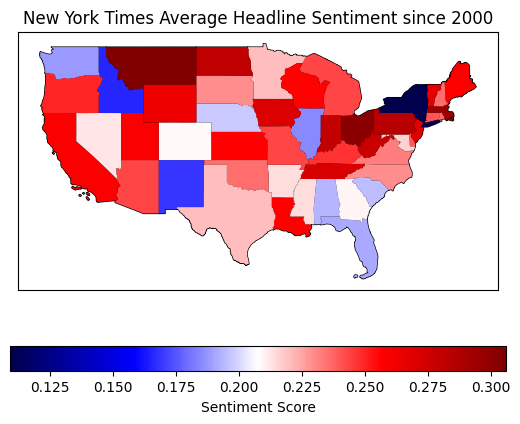

In [10]:

fig, ax = plt.subplots()
ax.title.set_text('New York Times Average Headline Sentiment since 2000')
#Only include continental US in plot
not_continental = ['Puerto Rico', 'Alaska', 'Hawaii']
plot_data = gdf_sentiment.loc[~gdf_sentiment['state'].isin(not_continental)]
# include a border
plot_data.plot(ax = ax, color='white', edgecolor='black')
# plot the map
plot_data.plot(
    ax = ax,
    column = 'headline_sentiment_score',
    cmap = 'seismic',
    legend = True,
    legend_kwds={'label': 'Sentiment Score', 'orientation': 'horizontal'},
    figsize = (16, 14)
)

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)

save_path = 'DATA\sentiment_map.png'
plt.savefig(save_path)
plt.show()

### Make some non-geographic plots

In [11]:
non_geo_plots = facts.merge(geo_subjects[['fact_id', 'state']], on = ['fact_id'])

In [12]:
non_geo_plots['publication_date'] = pd.to_datetime(non_geo_plots['publication_date'])
non_geo_plots['publication_year'] = non_geo_plots['publication_date'].dt.year



### See which news desks are most positive and most negative

> Only including desks with at least 25 articles


In [13]:
news_desks = spark.sql('SELECT * FROM nyt.db.dim_news_desks')
news_desks = news_desks.toPandas()

news_desk_scoring = non_geo_plots[['news_desk_id', 'state', 'headline_sentiment_score']].merge(news_desks, on = ['news_desk_id'])
# To see which desks are most positive and negative, only include news desks with at least 25 articles in the dataset
filter_25 = news_desk_scoring.groupby(['news_desk']).size().loc[lambda x: x >= 25].index

def pos_neg_desks():
    pos = news_desk_scoring.loc[news_desk_scoring['news_desk'].isin(filter_25)].\
        groupby(['news_desk'])['headline_sentiment_score'].mean().nlargest(5)
    neg = news_desk_scoring.loc[news_desk_scoring['news_desk'].isin(filter_25)].\
        groupby(['news_desk'])['headline_sentiment_score'].mean().nsmallest(5)

    
    return((pos, neg))

pos, neg = pos_neg_desks()

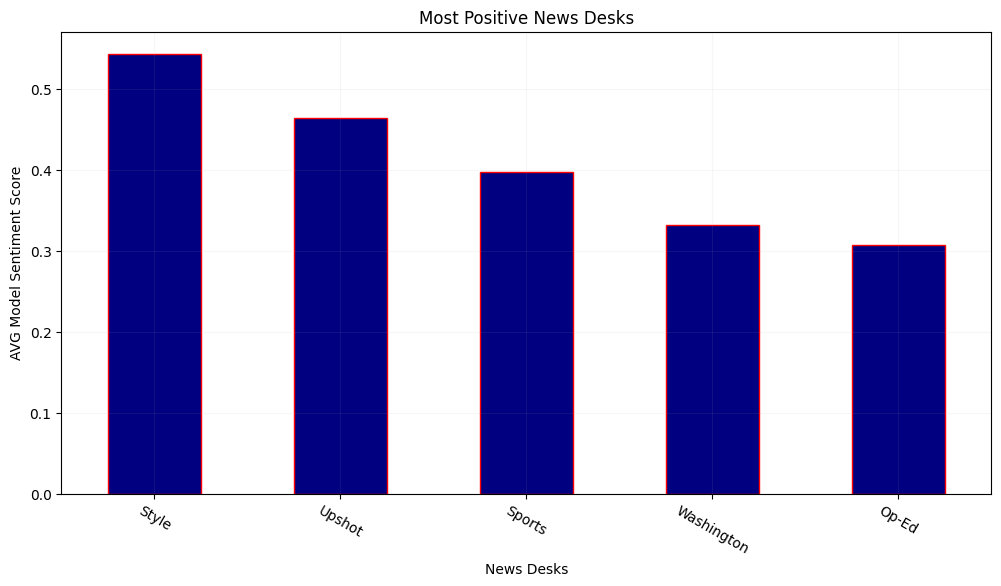

In [14]:
plt.figure(figsize = (12, 6))
plt.title('Most Positive News Desks')
pos.plot(kind = 'bar', color = 'navy', edgecolor = 'red')
plt.xticks(rotation=330)
plt.ylabel('AVG Model Sentiment Score')
plt.xlabel('News Desks')
plt.grid(alpha=0.1)
plt.savefig('DATA/positive_sentiment_news_desks.png')
plt.show()

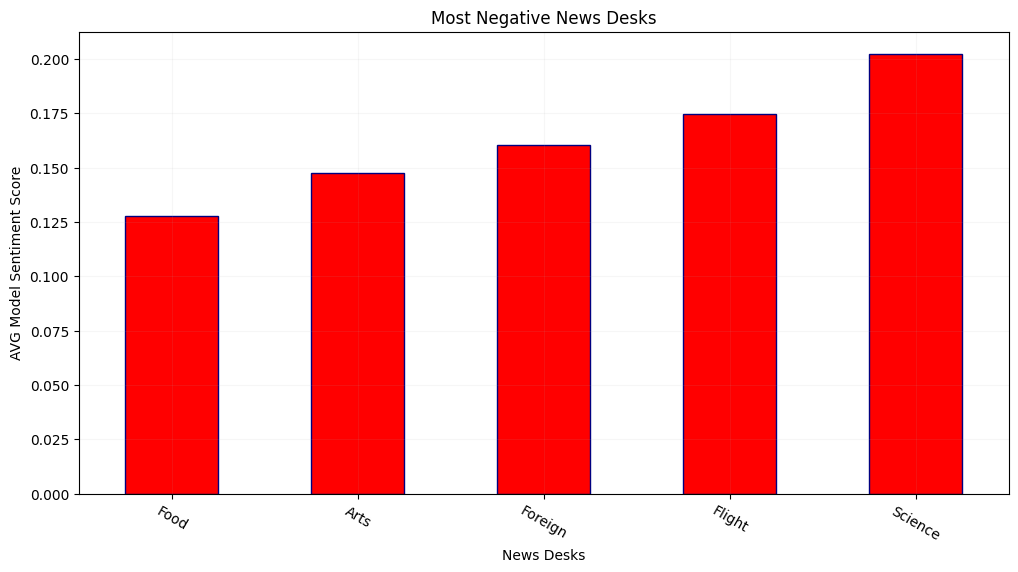

In [15]:
plt.figure(figsize = (12, 6))
plt.title('Most Negative News Desks')
neg.plot(kind = 'bar', color = 'red', edgecolor = 'navy')
plt.xticks(rotation=330)
plt.ylabel('AVG Model Sentiment Score')
plt.xlabel('News Desks')
plt.grid(alpha=0.1)
plt.savefig('DATA/negative_sentiment_news_desks.png')
plt.show()

### Analyze headline sentiment when the article is about certain people

In [16]:
subject_people = spark.sql('SELECT * FROM nyt.db.subject_people')
subject_people = subject_people.toPandas()
subject_people.head()

,table_id,fact_id,subject_id,subject_rank,major_subject,first_name,middle,last_name,qualifier
0,1515.000977,1515,1,6,False,JOHN,W,HICKENLOOPER,None
1,1527.001953,1527,1,4,False,DONALD,J,TRUMP,None
2,1579.001953,1579,1,15,False,MITT,None,ROMNEY,None
3,1665.000977,1665,1,3,False,SUE,None,MANNING,None
4,2251.000977,2251,1,1,False,L,TAMMY,DUCKWORTH,None


In [17]:
### Make one column for the entire name
subject_people['full_name'] = subject_people[['first_name', 'middle', 'last_name', 'qualifier']].apply(lambda x: ' '.join(x.dropna()), axis=1)
analyze_people = subject_people[['fact_id', 'full_name']]
analyze_people = analyze_people.merge(facts[['fact_id', 'headline_sentiment_score']], on = ['fact_id'])



In [18]:
# Who are they writing about the most and what is that person's sentiment scoring
from collections import Counter
#10 Most written about people in the dataset
top_10_people = Counter(analyze_people['full_name']).most_common(10)
print(top_10_people)

[('DONALD J TRUMP', 209), ('GEORGE W BUSH', 167), ('BARACK OBAMA', 117), ('JOSEPH R BIDEN JR', 85), ('MITT ROMNEY', 75), ('HILLARY RODHAM CLINTON', 61), ('AL GORE', 47), ('BERNARD SANDERS', 36), ('BILL CLINTON', 33), ('JOHN MCCAIN', 28)]


In [19]:
people_filter = [t[0] for t in top_10_people]
people_sentiment_plot = analyze_people.loc[analyze_people['full_name'].isin(people_filter)].\
    groupby(['full_name'])['headline_sentiment_score'].mean().sort_values(ascending = False)
people_sentiment_plot = pd.DataFrame(people_sentiment_plot).reset_index()

people_count_plot = pd.DataFrame(top_10_people, columns = ['full_name', 'article_count'])




C:\Users\1saml\AppData\Local\Temp\ipykernel_18180\1624300296.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(people_count_plot['full_name'], rotation = 330)
C:\Users\1saml\AppData\Local\Temp\ipykernel_18180\1624300296.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(people_sentiment_plot['full_name'], rotation = 330)


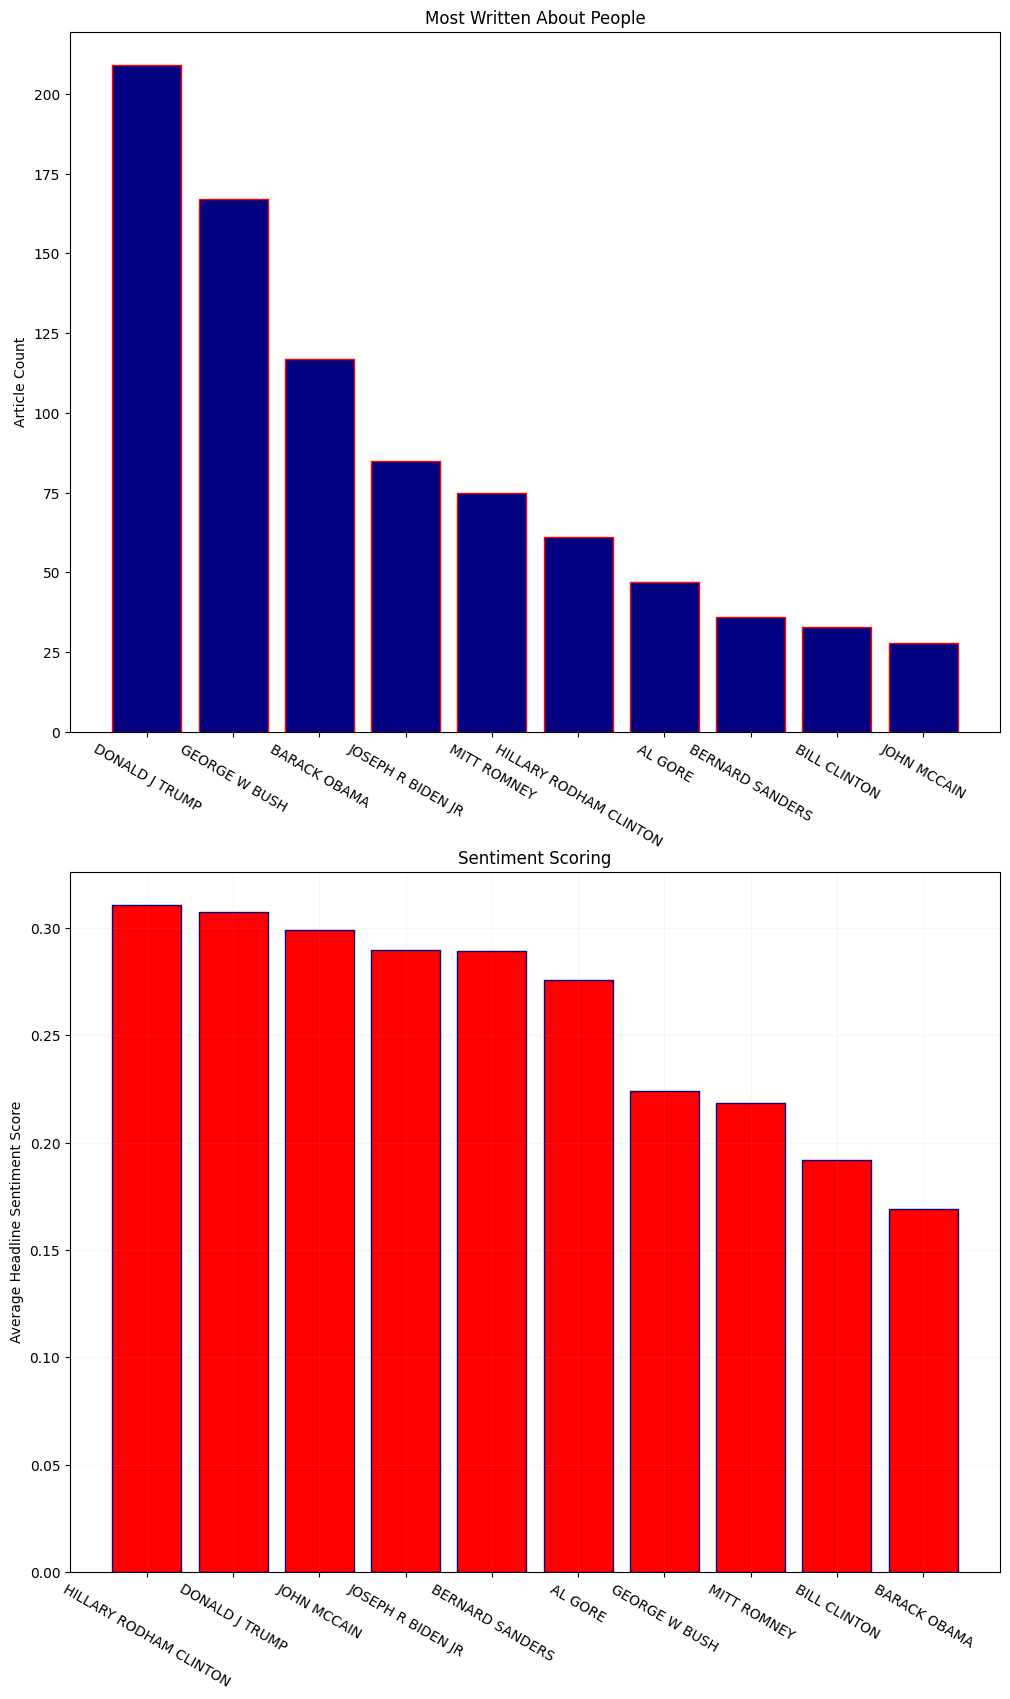

In [20]:
fig, axs = plt.subplots(2, figsize = (12, 20))

axs[0].bar(people_count_plot['full_name'], people_count_plot['article_count'], color = 'navy', edgecolor = 'red')
axs[0].set_ylabel('Article Count')
axs[0].set_title('Most Written About People')
axs[0].set_xticklabels(people_count_plot['full_name'], rotation = 330)

axs[1].bar(people_sentiment_plot['full_name'], people_sentiment_plot['headline_sentiment_score'], color = 'red', edgecolor = 'navy')
axs[1].set_ylabel('Average Headline Sentiment Score')
axs[1].set_title('Sentiment Scoring')
axs[1].set_xticklabels(people_sentiment_plot['full_name'], rotation = 330)
plt.grid(alpha = 0.1)
plt.savefig('DATA/most_written_about_people.png')
plt.show()